<a href="https://colab.research.google.com/github/ThuyHaLE/Image_processing/blob/main/Background_Replacement_%26_Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

#Background Substraction

In [162]:
def replaceBackGround(bg1_image, bg2_image, ob_image):
  difference_single_channel = computeDifference(bg1_image,ob_image)
  binary_mask = computeBinaryMask(difference_single_channel)
  output = np.where(binary_mask==255, ob_image, bg2_image)
  return output

In [163]:
def computeDifference(bg_img, input_img):
  difference_single_channel = cv2.absdiff(bg_img, input_img)
  difference_single_channel = (difference_single_channel.sum(axis=-1)/3.0).astype('int8')
  return difference_single_channel

In [170]:
def computeBinaryMask(difference_single_channel):
  binary_mask = np.where(difference_single_channel>=20,255,0)
  difference_binary = np.stack((binary_mask,)*3, axis=-1)
  return difference_binary

##Results

In [156]:
#Upload files
uploaded = files.upload()

Saving FakeBackground.png to FakeBackground.png
Saving OriginalBackground.png to OriginalBackground.png
Saving OriginalImage.png to OriginalImage.png


(699, 964, 3)
(480, 640, 3)


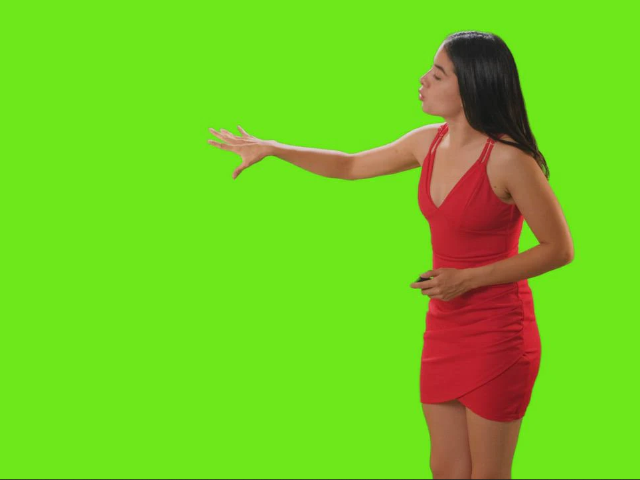

In [176]:
#OriginalImage
ori_image = cv2.imread('OriginalImage.png', 1)
print(ori_image.shape)
ori_image = cv2.resize(ori_image, (640, 480))
print(ori_image.shape)
cv2_imshow(ori_image)

(699, 964, 3)
(480, 640, 3)


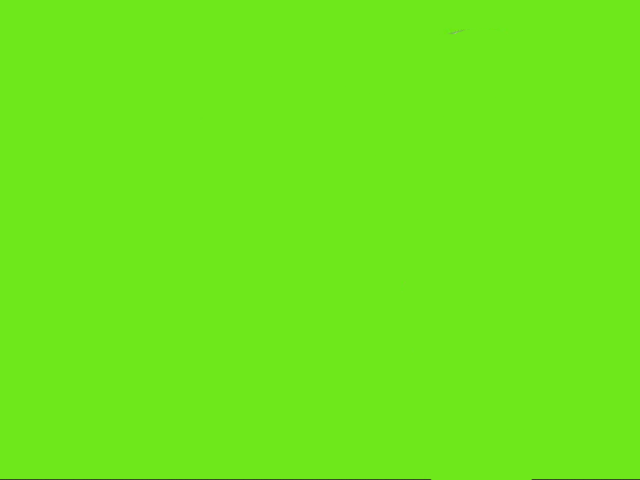

In [177]:
#OriginalBackground
bg1_image = cv2.imread('OriginalBackground.png', 1)
print(bg1_image.shape)
bg1_image = cv2.resize(bg1_image, (640, 480))
print(bg1_image.shape)
cv2_imshow(bg1_image)

(495, 880, 3)
(480, 640, 3)


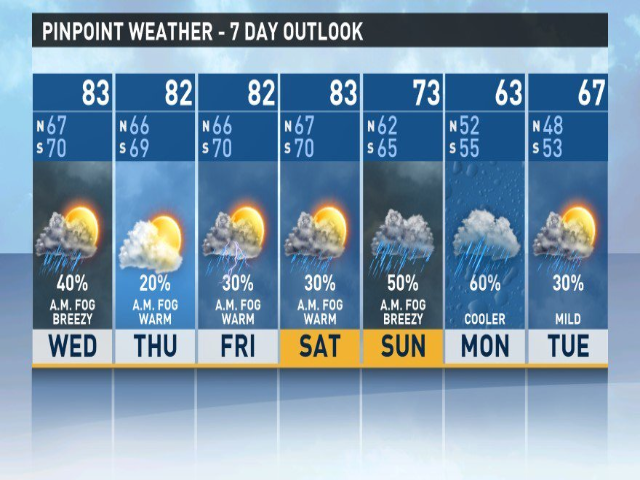

In [160]:
#FakeBackground
bg2_image = cv2.imread('FakeBackground.png', 1)
print(bg2_image.shape)
bg2_image = cv2.resize(bg2_image, (640, 480))
print(bg2_image.shape)
cv2_imshow(bg2_image)

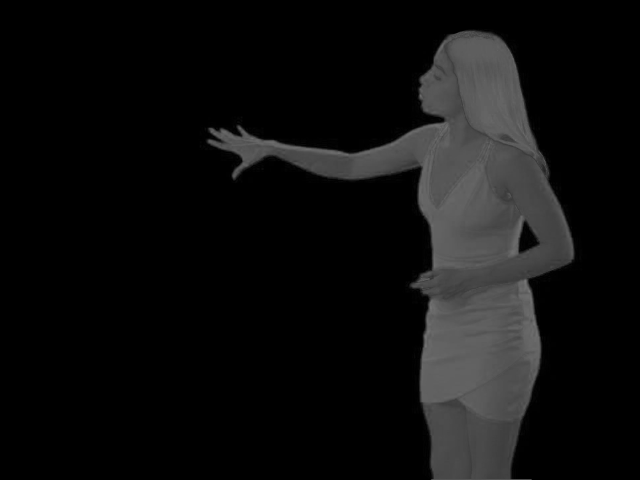

In [178]:
#Difference between the original image and original background
diff = computeDifference(bg1_image, ori_image)
cv2_imshow(diff)

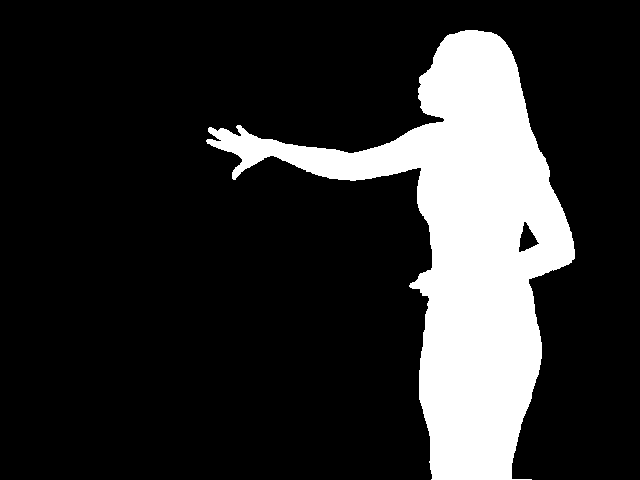

In [179]:
#Binary mask for the original image and original background
bina = computeBinaryMask(diff)
cv2_imshow(bina)

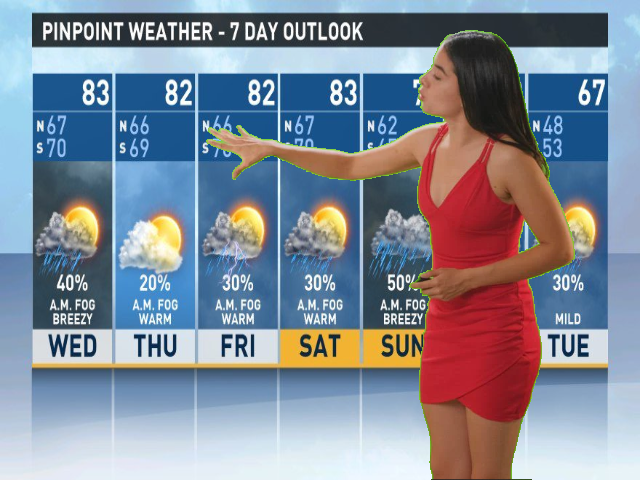

In [175]:
#Replace the original background with new background
new_image = replaceBackGround(bg1_image, bg2_image, ori_image)
cv2_imshow(new_image)

#Image Denoising

##Function

In [ ]:
#ConvertColorToGrayScale(3 chanels => 1 chanel)
#OpenCV uses BGR image format blue[0], green[1], red[2]
def convertColorToGrayScale(image):
  ratio = [0.0722, 0.7152, 0.2126] #red(0.2126), green (0.7152), and blue (0.0722) => grayscale
  grayscale = np.zeros(image.shape)
  for i in range(len(ratio)):
    grayscale[:,:,i] = image[:,:,i]*ratio[i]
  img_gray = grayscale.sum(axis=-1)
  return np.around(img_gray)

In [ ]:
#compute Root Mean Square Error for two matrices (images)
def compute_rms_error(matrix1, matrix2):
  matrix1 = matrix1.flatten()
  matrix2 = matrix2.flatten()
  result = np.sqrt((1/len(matrix1))*sum((matrix2 - matrix1)*(matrix2 - matrix1)))
  return result

In [ ]:
# Add Gaussian noise to input image
def addNoiseToImage(image, mean = 0, stddev= 25):
  noise = np.random.normal(mean, stddev, image.shape)
  noise = np.where(noise > 0 , np.around(noise), 0).astype('uint8')
  noisy_img = cv2.add(image,noise)
  return noisy_img

In [ ]:
#find the best sigma in the given sigma range => so that the rmse between the noise image and the original image is the smallest
def find_best_sigma_image_denoise(noise_image, orignial_image, sigma_range = 1000):
  u, s, vh = np.linalg.svd(noise_image,full_matrices=False)
  evaluation_history = []
  for i in range(1, sigma_range):
    s_cleaned = np.where(s > i, s, 0)
    img_denoised = np.array(np.dot(u*s_cleaned,vh))

    error = compute_rms_error(orignial_image, img_denoised)
    evaluation_history.append(error)

  best_index = evaluation_history.index(min(evaluation_history))
  return best_index, evaluation_history

In [ ]:
#Denoise image by a given sigma_ threshold (remove all sigma values < sigma_ threshold)
def perform_image_denoise(noise_image, sigma_threshold):
  u, s, vh = np.linalg.svd(noise_image,full_matrices=False)
  s_cleaned = np.where(s > sigma_threshold, s, 0)
  img_denoised = np.array(np.dot(u*s_cleaned,vh))
  return img_denoised

In [ ]:
#Plot RMSE by Sigma Threshold
def plot_chart_based_rmse():
  plt.plot(evaluation_history)
  plt.xlabel("Sigma Threshod")
  plt.ylabel("RMSE")
  plt.show()

##Results

In [ ]:
uploaded = files.upload()

Saving cat.jpeg to cat.jpeg


(1280, 1225, 3)
(1000, 1000, 3) uint8
(1000, 1000) float64


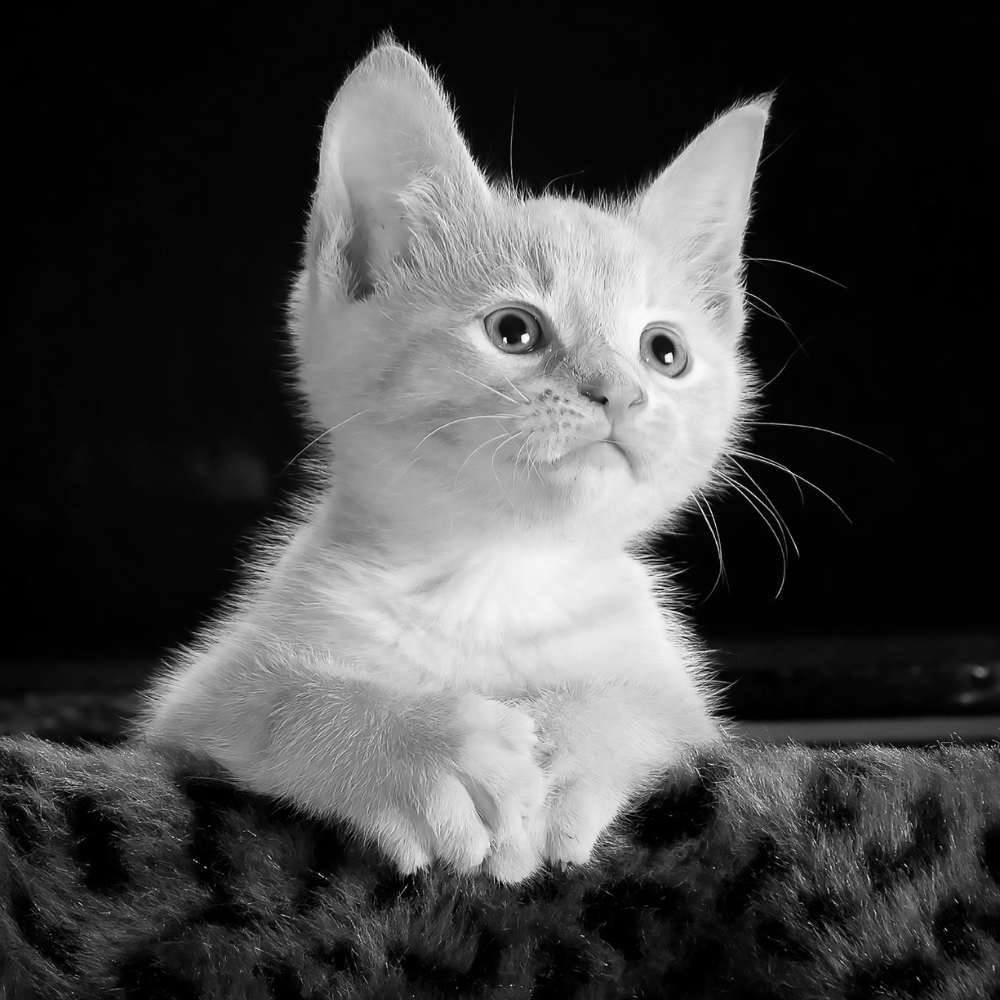

In [ ]:
image = cv2.imread('/content/cat.jpeg') #/content/your_file_name
print(image.shape)
image = cv2.resize(image, (1000,1000))
print(image.shape, image.dtype)

gray_image = convertColorToGrayScale(image)
print(gray_image.shape, gray_image.dtype)
cv2_imshow(gray_image)

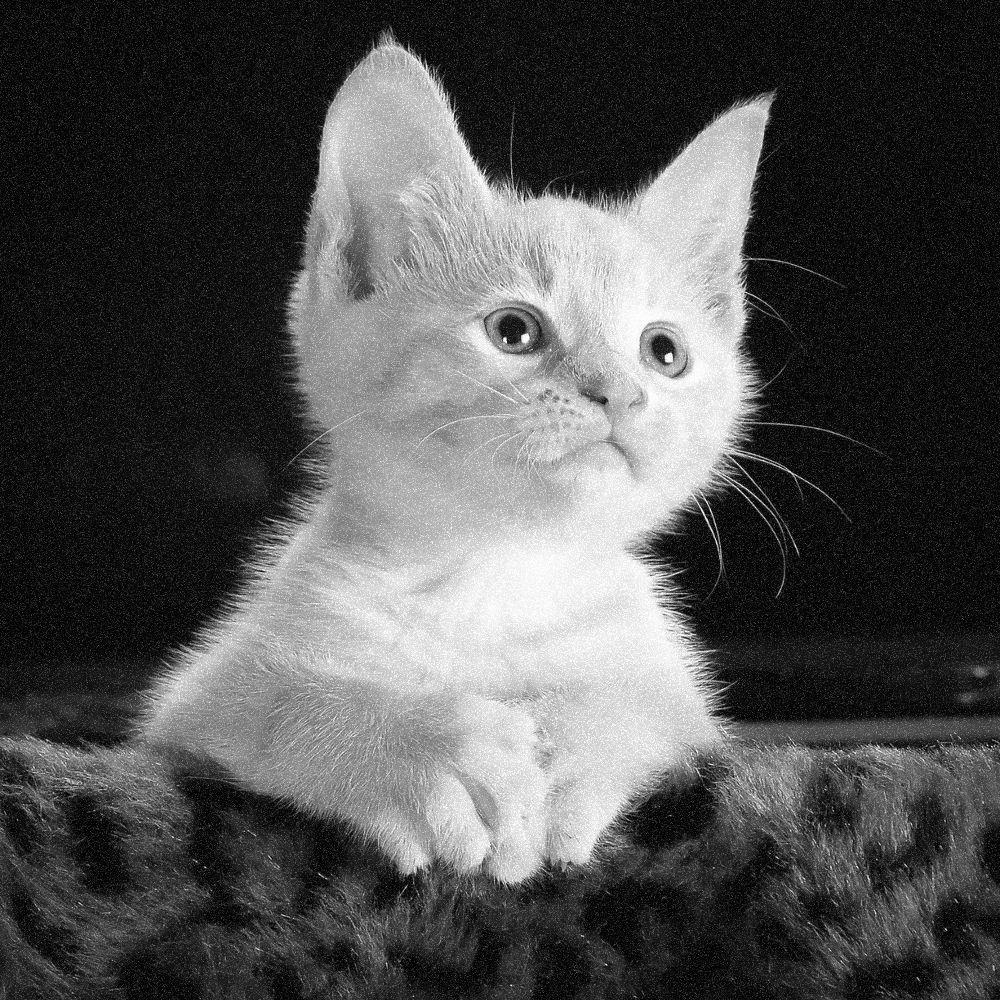

In [ ]:
# Add Gaussian noise to input image
noise_image = addNoiseToImage(image,mean = 0, stddev= 30)
gray_noise_image = convertColorToGrayScale(noise_image)
cv2_imshow(gray_noise_image )

gray_denoise_rmse 17.379324814
gray_denoise_rmse 16.16352886


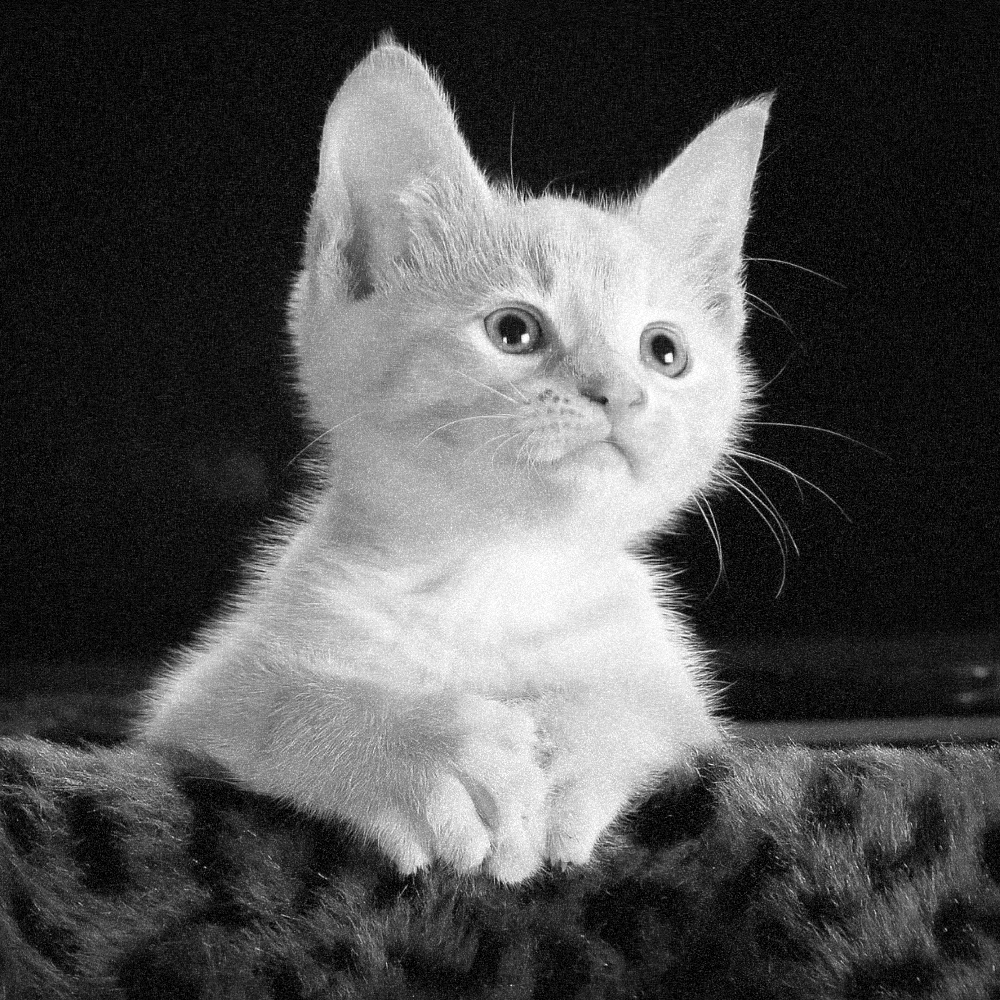

In [ ]:
#Denoise image by a given sigma_ threshold = 600
denoise_image = perform_image_denoise(gray_noise_image, sigma_threshold=600)
print("gray_denoise_rmse", round(compute_rms_error(gray_image,gray_noise_image),9))
print("gray_denoise_rmse", round(compute_rms_error(gray_image,denoise_image),9))
cv2_imshow(denoise_image)

best threshold: 883, best rmse: 15.49662169956708
gray_denoise_rmse 17.379324814
gray_denoise_rmse 15.496942206


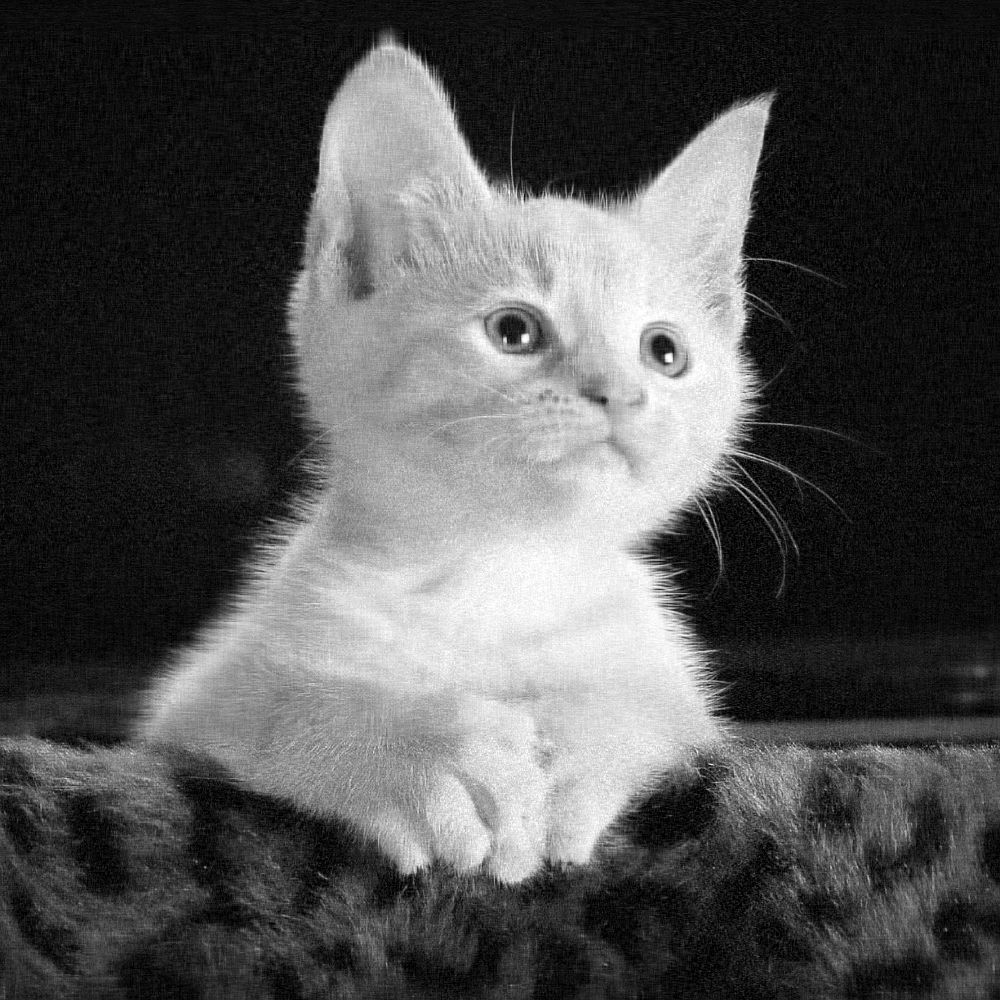

In [ ]:
#find the best sigma in the given sigma range
best_index, evaluation_history = find_best_sigma_image_denoise(gray_noise_image, gray_image, sigma_range = 1500)
print(f'best threshold: {best_index}, best rmse: {evaluation_history[best_index]}')
#Denoise image by a given sigma_ threshold = best threshold
denoise_image = perform_image_denoise(gray_noise_image, sigma_threshold=best_index)
print("gray_denoise_rmse", round(compute_rms_error(gray_image,gray_noise_image),9))
print("gray_denoise_rmse", round(compute_rms_error(gray_image,denoise_image),9))
cv2_imshow(denoise_image)

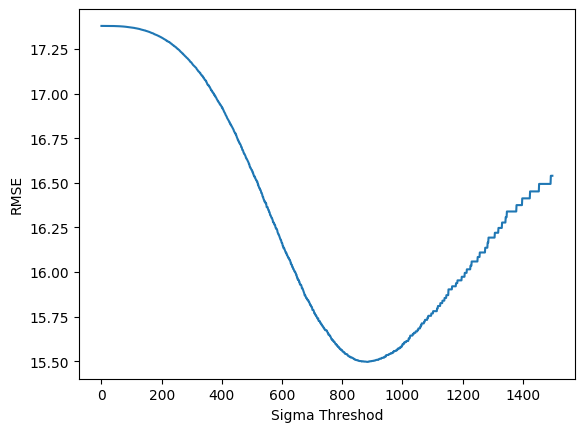

In [ ]:
#Plot RMSE by Sigma Threshold
plot_chart_based_rmse()